In [ ]:
!pip install --upgrade matplotlib > None # need refresh enviroment after installation

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
!pip install basemap > None

In [22]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

%matplotlib inline

### **Подготовительный этап (взят с первого дз)**

In [2]:
path = 'dataset_model.csv'
df = pd.read_csv(path, index_col='Unnamed: 0') # загружаем датасет

In [3]:
df.head()

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,...,y_15,y_16,y_17,y_18,y_19,a1,a2,b1,b2,u
0,0.0,103.470474,169.841497,202.634886,217.431860,223.846126,226.572989,227.720839,228.201543,228.402313,...,228.545105,228.545542,228.545724,228.545800,228.545832,4.768043,4.528949,4.114231,4.197650,47.730118
1,0.0,47.284430,89.774170,113.979345,122.004075,120.914403,116.870131,113.302064,111.296707,110.649611,...,111.610162,111.580655,111.555527,111.541783,111.537599,2.332872,1.885917,2.314809,3.828850,31.755654
2,0.0,12.003113,22.219190,29.660820,34.898547,38.553882,41.099383,42.871039,44.103927,44.961858,...,46.701930,46.769713,46.816880,46.849702,46.872541,2.255614,3.962950,2.019615,2.178595,10.395001
3,0.0,5.945856,13.330533,19.974172,25.229365,29.101800,31.827782,33.685357,34.920257,35.725122,...,37.019445,37.047172,37.063602,37.073242,37.078841,1.005294,1.969880,1.180354,3.752236,6.134611
4,0.0,61.878596,110.339668,142.663314,163.015963,175.527032,183.136670,187.742940,190.525090,192.203788,...,194.631042,194.679661,194.708971,194.726642,194.737294,2.334700,3.389631,3.470272,1.687632,33.804580


In [4]:
# Деление датасета на части
out_signal = df[['y_1', 'y_3', 'y_16','u']] # Значения выходного сигнала. Для каждого эксперимента снято по 20 точек
input_signal = df[['u']] # Значения входного сигнала.
coefficients = df[['a1', 'a2', 'b1', 'b2']] # Коэффициенты модели

In [5]:
scaler = StandardScaler()
X_array = scaler.fit_transform(out_signal)
y_array = df[['a1', 'a2', 'b1', 'b2']]
X_array.shape, y_array.shape

((300, 4), (300, 4))

In [6]:
X_array = pd.DataFrame(X_array, columns=['y_1', 'y_3', 'y_16','u'])
type(X_array), X_array.shape

(pandas.core.frame.DataFrame, (300, 4))

Проведем разбиение на обучающую (75%) и тестовую (25%) выборки при помощи train_test_split:

In [7]:
X_array_train, X_array_test, Y_array_train, Y_array_test = train_test_split(X_array, y_array, test_size=0.25, random_state=0)
X_array_train.shape, X_array_test.shape, Y_array_train.shape, Y_array_test.shape # Проверка, что все поделилось 75/25

((225, 4), (75, 4), (225, 4), (75, 4))

In [8]:
type(X_array_train)

pandas.core.frame.DataFrame

# **1. Построить более сложную модель с подбором гиперпараметров**

### **Подбор и оптимизация гиперпараметров с использованием кросс-валидации. Grid Search**

In [9]:
regr = Pipeline([("scaler", StandardScaler()), ("reg", RandomForestRegressor(random_state=0)),])

In [10]:
parameters = {
    'reg__n_estimators': range(100, 1100, 100), # Задали произвольно
    'reg__max_depth': range(1, 30, 5), # Задали произвольно
}

gridregr = GridSearchCV(regr, parameters, cv=5)
gridregr.fit(X_array_train, Y_array_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reg',
                                        RandomForestRegressor(random_state=0))]),
             param_grid={'reg__max_depth': range(1, 30, 5),
                         'reg__n_estimators': range(100, 1100, 100)})

In [11]:
best_parameters = gridregr.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}") #Смотрим, что подставить в параметры для обучения модели на гиперпараметрах

reg__max_depth: 16
reg__n_estimators: 500


In [13]:
rf_reg = gridregr.best_estimator_
predictions = rf_reg.predict(X_array_test)
mean_squared_error(Y_array_test, predictions)

0.8087057494389229

# **2. Проинтерпретировать полученную модель**

В первом домашнем задании для обучения модели использовался метод Линейной регрессии.

RMSE в том случае была равна 0.8035

При использовании гиперпараметров и ансамблировании RMSE стала равна 0.8

Определим значимость признаков

In [23]:
type(X_array)

numpy.ndarray

In [16]:
# Поиск наиболее важных признаков
features = {}
for i in range(len(X_array.columns)):
    features[rf_reg.feature_names_in_[i]] = rf_reg._final_estimator.feature_importances_[i]

In [17]:
features = sorted( features.items(), key=lambda pair: pair[1], reverse=True )[:20]
features

[('y_16', 0.3304308918689315),
 ('y_1', 0.27336777638022675),
 ('u', 0.24821136856630446),
 ('y_3', 0.14798996318453733)]

Mean Decrease Impurity

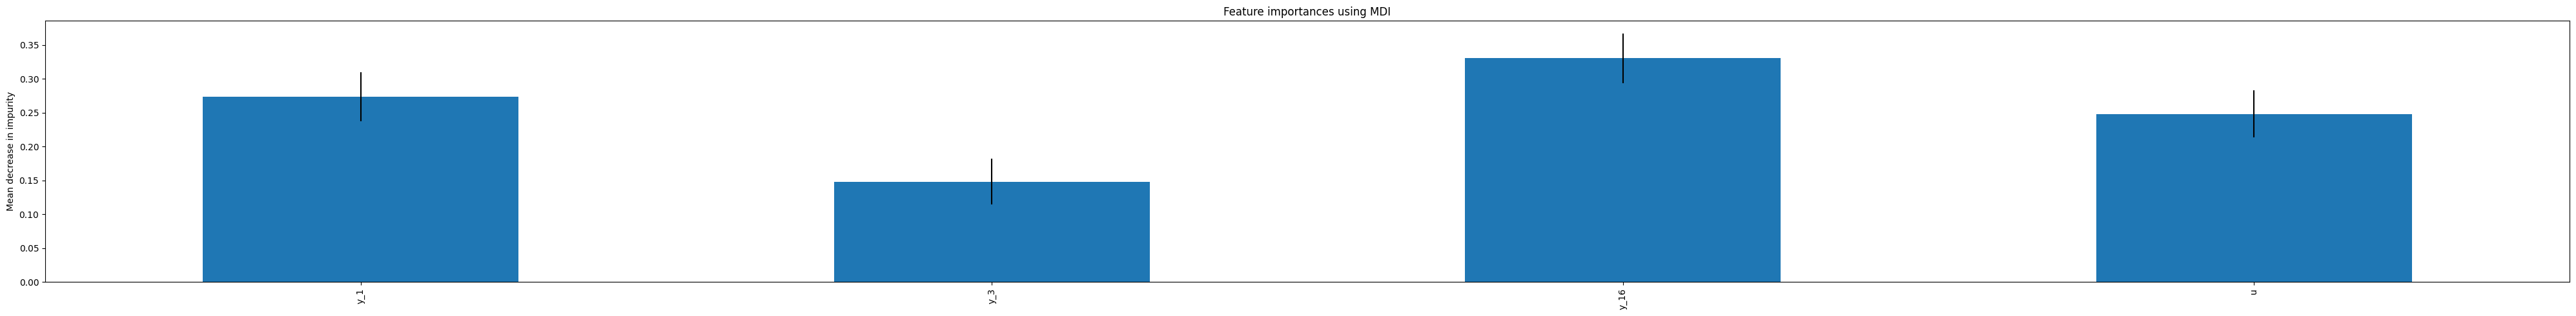

In [18]:
forest_importances = pd.Series(rf_reg._final_estimator.feature_importances_, index=X_array_train.columns)

fig, ax = plt.subplots(figsize=(40, 5))
std = np.std([tree.feature_importances_ for tree in rf_reg._final_estimator.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", )
fig.tight_layout()

Permutation importances

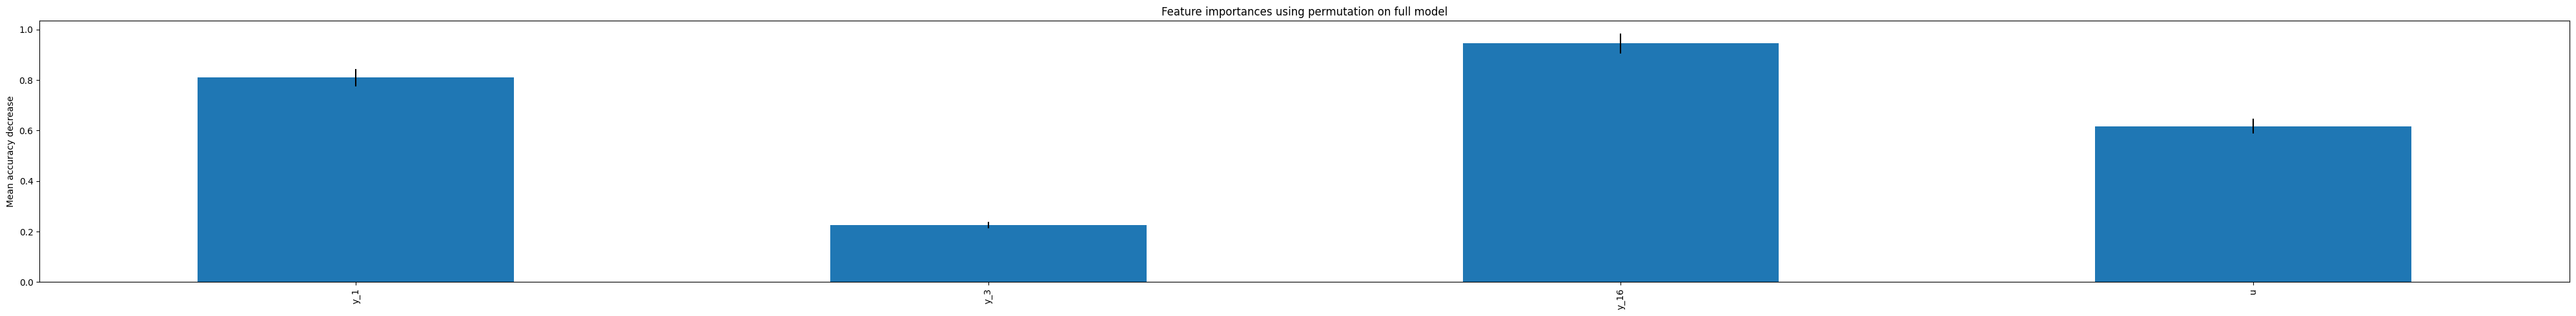

In [20]:
# Переставим признаки местами, чтобы проверить их важность

importances = permutation_importance(rf_reg, X_array_train, Y_array_train, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_array_train.columns)

fig, ax = plt.subplots(figsize=(40, 5))
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Результаты анализа признаков показали, что наиболее важными являются выходные сигналы установки в начале и конце временного интервала измерений. Промежуточные значения играют существенно мене важную роль. Также значмым является подаваемый на систему сигнал управления.

Экспертное мнение: полученные значения RMSE, позволяют сделать вывод о более высоком качестве работы модели на основе случайного леса. Оцека важности признаков говорит о необходимости использования начальных и конечных значений выходного сигнала, а также амплитуды входного.